In [1]:
import os
import torch 
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchmetrics import StructuralSimilarityIndexMeasure

from sde import VPSDE
from models.unet import UNet
from loss import get_sde_loss_fn
from configs.config import CFGS
from train import Step_by_Step
from dataset import myDataset

In [2]:
# Define the sde
vpsde = VPSDE(N=1500)

# Define the models
model_config = CFGS["model"]
model_xy = UNet(**model_config)
model_yx = UNet(**model_config)

models = (model_xy, model_yx)

# Define the loss function
loss_fn = get_sde_loss_fn(sde=vpsde)

# Define the optimizer
optimizer_xy = optim.Adam(model_xy.parameters(), lr=CFGS["optim"]["lr"], betas=(CFGS["optim"]["beta1"], 0.999), 
                       eps=CFGS["optim"]["eps"], weight_decay=CFGS["optim"]["weight_decay"])

optimizer_yx = optim.Adam(model_yx.parameters(), lr=CFGS["optim"]["lr"], betas=(CFGS["optim"]["beta1"], 0.999), 
                       eps=CFGS["optim"]["eps"], weight_decay=CFGS["optim"]["weight_decay"])

optimizers = (optimizer_xy, optimizer_yx)

In [3]:
# Instantiate the step by step class
sbs = Step_by_Step(sde=vpsde, models=models, loss_fn=loss_fn, optimizers=optimizers, config=CFGS)
ssim = StructuralSimilarityIndexMeasure()

/home2/msdg35/myjupyterenv/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `SSIM` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [27]:
dataset_dir = "./datasets/maps"
img_size = CFGS["model"]["image_size"]

transforms = Compose(
    [Resize((img_size, img_size)),
     ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = myDataset(
    root_img= os.path.join(dataset_dir, "train"),
    transform=transforms
)


loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

In [5]:
sbs.load_checkpoint("./checkpoints/checkpoint.pth")

In [28]:
x, y = next(iter(loader))

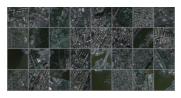

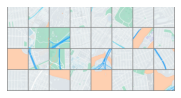

In [29]:
sbs.plot_samples(x)
sbs.plot_samples(y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


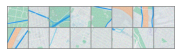

In [10]:
sample_y = sbs.translate(target_domain="y", condition=x, num_steps=50)
sbs.plot_samples(sample_y)

In [30]:
ssim_scores = dict()

In [31]:
sample_y = sbs.translate(target_domain="y", condition=x, num_steps=10)
ssim_scores["10"] = ssim(y, sample_y).tolist()

sample_y = sbs.translate(target_domain="y", condition=x, num_steps=100)
ssim_scores["100"] = ssim(y, sample_y).tolist()

sample_y = sbs.translate(target_domain="y", condition=x, num_steps=250)
ssim_scores["250"] = ssim(y, sample_y).tolist()

sample_y = sbs.translate(target_domain="y", condition=x, num_steps=500)
ssim_scores["500"] = ssim(y, sample_y).tolist()

sample_y = sbs.translate(target_domain="y", condition=x, num_steps=1000)
ssim_scores["1000"] = ssim(y, sample_y).tolist()

sample_y = sbs.translate(target_domain="y", condition=x, num_steps=1500)
ssim_scores["1500"] = ssim(y, sample_y).tolist()

In [32]:
ssim_scores

{'10': -0.08681700378656387,
 '100': 0.6759231090545654,
 '250': 0.9435979723930359,
 '500': 0.9853986501693726,
 '1000': 0.9819154739379883,
 '1500': 0.9774670600891113}

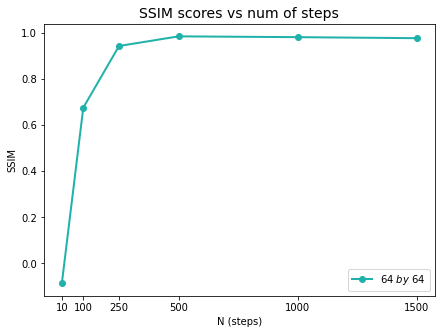

In [45]:
import matplotlib.pyplot as plt
import numpy as np

nsteps = list(map(int, list(ssim_scores.keys())))
ssim_list = list(ssim_scores.values())

# plot the figure
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(nsteps, ssim_list, marker='o', color='lightseagreen', linewidth=2, label='$64~by~64$')
ax.set_title(label="SSIM scores vs num of steps", fontdict={'fontsize':14})
plt.xticks(nsteps, nsteps)
ax.set_xlabel('N (steps)')
ax.set_ylabel('SSIM')
plt.legend()
plt.show()